<h1>Nuclear Fusion Cross Sections</h1>

<p>Copyright (C) 2022 Universidad Politécnica de Madrid</p>
<p>Author: Manuel Cotelo Ferreiro (manuel.cotelo@upm.es)</p>

<h2>Introduction</h2>

<h2>Load Cross Sections from CSV file</h2>

<h3>0. Define some utilities</h3>

In [18]:
import argparse
import itertools
import json

import numpy

import scipy.interpolate
import scipy.integrate
import scipy.optimize

import matplotlib.pyplot as plt

units = argparse.Namespace(
    mass = argparse.Namespace(
        amu_to_eV = 931.49406121e+06,
        amu_to_keV = 931.49406121e+03,
        amu_to_MeV = 931.49406121e+00,
    ),
    length = argparse.Namespace(
        m_to_cm = 1.e-2,
    ),
    xs = argparse.Namespace(
        barn_to_cm2 = 1.e-24,
    ),
    temperature = argparse.Namespace(
        eV_to_keV = 1.e-3,
    ),
)

ks = argparse.Namespace(
    mass = 'mass_value',
    z = 'Z',
    a = 'A',
)

cphys = argparse.Namespace(
    c_light = 299792458., # m/s
)

# name of nuclear data database
file_db = 'dbnuc.json'

# load database
db = json.load(open(file_db,'r'))

# define names of particles
nm1 = 'h2'
nm2 = 'h3'
nm3 = 'n1'
nm4 = 'he4'

# get mass of reactives from DB
m1 = db[nm1][ks.mass]*units.mass.amu_to_MeV # deuterium
m2 = db[nm2][ks.mass]*units.mass.amu_to_MeV # tritium

# get mass of products from DB
m3 = db[nm3][ks.mass]*units.mass.amu_to_MeV # neutron
m4 = db[nm4][ks.mass]*units.mass.amu_to_MeV # alpha

<h3>1. Load data</h3>

<p>Select reaction T(d,n)He4</p>

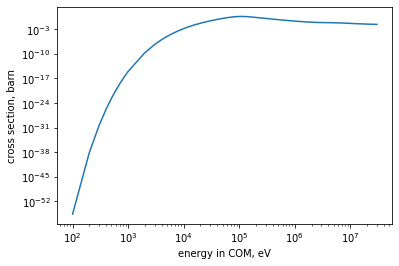

In [19]:
# define file anem with data in CSV format
file_name = 'janis/DT/xs.csv'

# load data
data = numpy.genfromtxt( file_name, delimiter=';', )

# select data
en, xs = data[:,0], data[:,2]

# validate data, remove NaN (not-a-number)
ms = numpy.isfinite(en) & numpy.isfinite(xs)
en, xs = en[ ms ], xs[ ms ]

# build an interpolation functor to evaluate the cross section for any energy
func_xs = scipy.interpolate.interp1d( en, xs, bounds_error=False, fill_value=( 0., 0., ), ) # return 0. on extrapolation

# plot cross section
fig = plt.figure()

plt.xlabel('energy in COM, eV')
plt.ylabel('cross section, barn')

plt.xscale('log')
plt.yscale('log')

plt.plot(en,xs)

plt.show()

<h2>2. Define Maxwell distribution</h2>

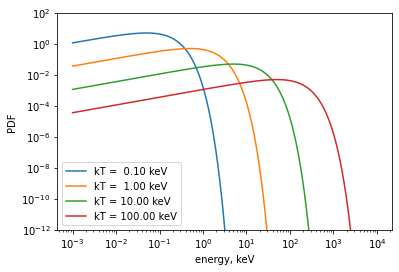

In [3]:
# define a functor for the maxwellian distribution
class maxwell_dist_c():
    
    def __init__(self,kt):
        # validate parameters
        assert kt > 0., 'Temperature must be greater than 0.0'
        
        # save parameters
        self.kt = kt
        
        # define auxiliar variable
        self.f0 = 2./numpy.power(self.kt,3./2.)/numpy.sqrt(numpy.pi)
    
    def __call__(self,e):
        return self.f0*numpy.sqrt(e)*numpy.exp(-e/self.kt)

# 
# test distro
#

# define maxwellian
kt = [ 0.1, 1., 10., 100., ] # in keV
funcs = [ maxwell_dist_c(kti) for kti in kt ]

# define an energy mesh
e_lo, e_hi, e_num = 1.e-3, 1.e+4, 500
es = numpy.exp(numpy.linspace(numpy.log(e_lo),numpy.log(e_hi),e_num))

# plot maxwellian
fig = plt.figure()

plt.xlabel('energy, keV')
plt.ylabel('PDF')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1.e-12,1.e+2)

for kti, fi in zip(kt,funcs):
    plt.plot(es,fi(es),label=f'kT = {kti:5.2f} keV')

plt.legend()

plt.show()


<h2>3. Average cross section</h2>

<p>The averaged cross section formula that depends on energy is</p>

\begin{align}
\langle \sigma \cdot v \rangle = \sqrt{\frac{8}{\pi \mu}} \left( k T \right)^{-3/2} \int_{0}^{\infty} E \cdot \sigma (E) \exp{\left(-\frac{E}{kT}\right)} dE 
\end{align}

<p>Be very careful withn units: we are using units of energy for mass, then we are going to obtain the cross section divided by the speed of light, $\langle \sigma \cdot v \rangle / c = \langle \sigma \cdot \frac{v}{c} \rangle$, and then it will have the same units as $\sigma$.</p>
</p>

\begin{align}
\end{align}

In [26]:
# function to evaluate cross section
def xsaverage_value(mu,kt,func_sigma):
    # validate parameters
    assert mu > 0., 'Particle mass must be greater than 0.0 !!!'
    assert kt > 0., 'Temperature must be greatewr than 0.0 !!!'
    # compute constant
    q = numpy.sqrt(8./mu/numpy.pi)*numpy.power(kt,-3./2.)
    # define integrand
    fi = lambda e: e*func_xs(e)*numpy.exp(-e/kt)
    # chop integral in several pieces, define edges
    edges = [ 0, 0.01*kt, 0.1*kt, kt, 10.*kt, 100.*kt, numpy.inf, ]
    # do integral, chop it in several pieces
    w = numpy.sum( [ scipy.integrate.quad( fi, el, eh, limit=200, )[0] for el, eh in zip(edges[:-1],edges[1:]) ], )
    return q*w

# get reduced mass
mu = m1*m2/(m1 + m2)

# define a mesh of temperatures
kt_lo, kt_hi, kt_num = 1.e+0, 1.e+8, 100
kts = numpy.exp(numpy.linspace(numpy.log(kt_lo),numpy.log(kt_hi),kt_num))

# evaluate averages cross sections
sv = numpy.array( [ xsaverage_value(mu,kti,func_xs) for kti in kts ], )

# build an interpolator for averaged cross sections
func_sv = scipy.interpolate.interp1d( kts, sv, bounds_error=False, fill_value=numpy.nan, )

<ipython-input-26-1752ae1ebe56>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  w = numpy.sum( [ scipy.integrate.quad( fi, el, eh, limit=200, )[0] for el, eh in zip(edges[:-1],edges[1:]) ], )


) missing from current font.kages/IPython/core/pylabtools.py:134: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


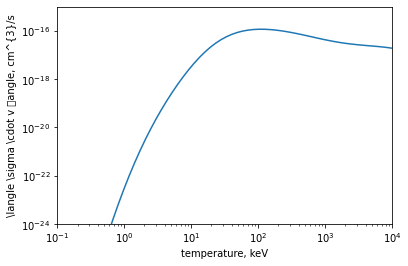

In [27]:
# plot results
fig = plt.figure()

plt.xlabel('temperature, keV')
plt.ylabel('\langle \sigma \cdot v \rangle, cm^{3}/s')

plt.xscale('log')
plt.yscale('log')

plt.xlim(1.e-1,1.e4,)
plt.ylim(1.e-24,1.e-15)

plt.plot(kts*units.temperature.eV_to_keV,sv*(cphys.c_light*units.length.m_to_cm)*units.xs.barn_to_cm2)

plt.show()

<p>At this point we must take our look back to the previous steps: out cross section data is defined for some range of energies. In fact, we defined oput interpolator for cross sections to return 0.0 in case of extrapolation but in the average of the cross section we are extending the integral to infinity. Then, are these steps right? For sure, this method is an aproximation that work fine when the temperature $k T$ is well within the range of the data of the cross sections. We will try to show this though an example: consider that out cross section is constant, $\sigma(E) = \sigma_{0}$.</p>
    
\begin{align}
\langle \sigma \cdot v \rangle & = \sqrt{\frac{8}{\pi \mu}} \left( k T \right)^{-3/2} \int_{0}^{\infty} E \cdot \sigma (E) \exp{\left(-\frac{E}{kT}\right)} dE \\
& = \sqrt{\frac{8}{\pi \mu}} \left( k T \right)^{-3/2} \sigma_{0} \int_{0}^{\infty} E \cdot \exp{\left(-\frac{E}{kT}\right)} dE 
\end{align}

<p>For this example, our calculations approximate the last of the integrals in this way:</p>

\begin{align}
\int_{0}^{\infty} E \cdot \exp{\left(-\frac{E}{kT}\right)} dE \simeq \int_{E_{lo}}^{E_{hi}} E \cdot \exp{\left(-\frac{E}{kT}\right)} dE
\end{align}

<p>The error of this approximation is good when the area under the tail of the distribuiton above $E_{hi}$ is neglible respect to the total area. The same for the area below $E_{lo}$. Then, let's improve the results returning some confidence partameter.</p>

<ipython-input-8-1100d986fee4>:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  whi = scipy.integrate.quad( fi, en_hi, numpy.inf, limit=200, )[0]
) missing from current font.kages/IPython/core/pylabtools.py:134: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


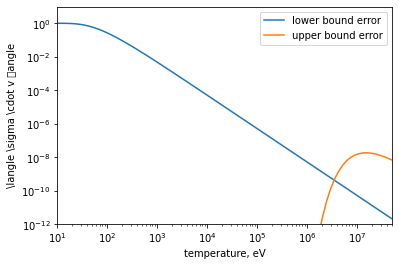

In [8]:
# compute error estimation in cross sections
def xsaverage_error(kt,en_lo,en_hi):
    # validate parameters
    assert kt > 0., 'Temperature must be greater than 0.0 !!!'
    assert en_lo > 0., 'Energy must be postive defined !!!'
    assert en_lo <= en_hi, 'Wrong definition of energy range'
    # chop integral in several pieces, define edges
    edges = [ 0, 0.01*kt, 0.1*kt, kt, 10.*kt, 100.*kt, numpy.inf, ]
    # define integrand function
    fi = lambda e: e*numpy.exp(-e/kt)
    # do integrals and reduce
    wtot = numpy.sum( [ scipy.integrate.quad( fi, el, eh, limit=200, )[0] for el, eh in zip(edges[:-1],edges[1:]) ], )
    # integrate head and tail
    wlo = scipy.integrate.quad( fi,    0.,     en_lo, limit=200, )[0]
    whi = scipy.integrate.quad( fi, en_hi, numpy.inf, limit=200, )[0]
    return numpy.abs(wlo/wtot), numpy.abs(whi/wtot)

# get energy range for data in cross sections
en_lo = numpy.amin(en)
en_hi = numpy.amax(en)

# compute error estimation
err = numpy.array( [ xsaverage_error(kti,en_lo,en_hi) for kti in kts], )

# plot results
fig = plt.figure()

plt.xlabel('temperature, eV')
plt.ylabel('\langle \sigma \cdot v \rangle')

plt.xscale('log')
plt.yscale('log')

plt.xlim(10.,5.e7,)
plt.ylim(1.e-12,1.e1)

plt.plot(kts,err[:,0],label='lower bound error')
plt.plot(kts,err[:,1],label='upper bound error')

plt.legend()

plt.show()

<h2>4. Approximate analytical formulas</h2>

<h2>5. Fit cross section data to model</h2>

<p>Nowadays we have available tools like Janis (NEA) that give us access to explore several nuclear datbases like EXFOR that includes experimental data for cross sections. As an exercise, we can reevaluate the values of the fitting parameters of the formulas given by Duane for the fusion cross section.</p>

<p>In this case, we will show a simple example and we weill consider the next model for the fusion cross section:</p>

\begin{align}
\sigma(E) = S_{0} \frac{1}{E} \exp \left( \frac{-b}{\sqrt{E}} \right)
\end{align}

<p>This parametrization includes only two parameters, anely $S_{0}$ and $b$. Parameter $S_{0}$ assumes a constant astrophysics factor for the cross section. On the other hand, models give exact values for parameter $b$ that is related to the tunneling effect but we left its value free for the fitting.</p>

In [9]:
# fitting function: first argument is the independent variables e, and the rest are the fitting parameters
fxs = lambda e, s0, b: s0*numpy.exp(-b/numpy.sqrt(e))/e

# do fitting
par_init = [ 1.e+5, 10., ]
par_opt, par_cov = scipy.optimize.curve_fit( fxs, en, xs, p0=param_init, )
par_opt, par_cov = scipy.optimize.curve_fit( fxs, en, xs, )

# define function
func_xs_fit = lambda e: fxs(e,par_opt[0],par_opt[1])

# plot results
fig = plt.figure()

plt.xlabel('energy, eV')
plt.ylabel('cross section, barns')

plt.xlim(1.e2,1.e8)
plt.ylim(1.e-12,1.e3)

plt.xscale('log')
plt.yscale('log')

plt.scatter(en,xs,label='evaluated datapoints from ENDF-VIII',marker='o')
plt.plot(en,func_xs_fit(en),label='approximated model',color='orange')

plt.legend()

plt.show()

NameError: name 'param_init' is not defined

<h2>6. Ignition criteria</h2>

<h2>7. Lawson criteria</h2>